In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
from skan import Skeleton, summarize
import skimage
import glob
import math
from tqdm import tqdm

## How it works:
### !MASK SHOULD NOT BE CROPPED - same resolution as the petri dishes images including the white strip
1. Load in mask (remove all small objects that are smaller than an average area of segmented instances)) (load_in_mask - function)
2. Determine primary roots locations (determine_primary_roots_locations - function)
3. Connect close enough starting nodes that lie in the area where seeds are supposed to be, helps with finding the highest starting point and avoiding errors with graphs analysis (connect_close_enough_starting_nodes - function)
    - Get all possible starting nodes for each plant (possible means that they lie in the assumed bounding box where the seed can lie (bounding box is derived from the template that was provided)) (get_all_possible_start_nodes_for_each_plant - function)
    - Finding the node (among all the possible nodes per plant)that is the closest to the center of the area where seeds are supposed to be (get_most_central_starting_node_for_each_plant - function)
    - loop through all the possible nodes for each plant and draw a line to connect it to the one that is closest to the center of the area where seeds are supposed to be
4. Segment primary roots (segmentation - function)
5. Segment lateral roots (colour_lateral_roots_based_on_starting_point - function) (change later)
6. Draw the segmentation on the image (last loop)

## To understand easier here are some images representing the outputs of the several functions:
- plant_bboxes -  image representing the bounding boxes for possible seeds position + the center of the box 'overlapping_roots/images_for_explanation/plants_bboxes.png'
- get_all_possible_start_nodes_for_each_plant - all starting nodes for each plant 'overlapping_roots/images_for_explanation/get_all_possible_start_nodes_for_each_plant.png'
- get_most_central_starting_node_for_each_plant - shows the starting nodes that are the closest to the center per each plant (not the best image - plants that don't have a point do not have a starting point in the bounding box for seeds 'overlapping_roots/images_for_explanation/get_most_central_starting_node_for_each_plant.png'
- determine_primary_roots_locations - primary root slice overlapping_roots/images_for_explanation/determine_primary_roots_locations.png

## Limitations that we have to fix and an image where it is visible
- Lateral root is not detected after removing small objects - overlapping_roots/overlapping_roots_segmented/000_43-18-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected_segmented.png
- Plant is present but not in the bounding box -> not detected - overlapping_roots/overlapping_roots_segmented/001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_segmented.png
- Lowest node is not from this plant - overlapping_roots/overlapping_roots_segmented/015_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected_segmented.png
- The shortest path is not the primary root - overlapping_roots/overlapping_roots_segmented/019_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_03-Fish Eye Corrected_segmented.png
- Primary roots is poorly detected as it's cut off in the slice image - overlapping_roots/overlapping_roots_segmented/031_43-18-ROOT1-2023-08-08_pvd_OD0001_col-0_05-Fish Eye Corrected_segmented.png (last plant) / overlapping_roots/overlapping_roots_segmented/001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_segmented.png (3rd plant)
- Protrusions from the primary root - overlapping_roots/overlapping_roots_segmented/006_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_02-Fish Eye Corrected_segmented.png

In [2]:
def load_in_mask(path):
    
    '''
    Takes in a path to the mask, loads it in, segments it, removes all the object that are smaller than an average area of all segmented instances, transfers the image back to BGR
    
    Args:
        path: path to an image

    Returns:
        mask wihthout small noise 
    '''
    
    # read the mask
    mask = cv2.imread(path, 0)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    #get the labels and stats
    # mask_seeding_position_label = skimage.measure.label(mask).astype('uint8')
    # _, template_segmented, stats, _ = cv2.connectedComponentsWithStats(mask_seeding_position_label)
    # 
    # #remove objects that are smaller than the average area
    # template_segmented = skimage.morphology.remove_small_objects(template_segmented, np.mean(stats[1:,4]))
    # 
    # #transfer image back to BGR
    # template_segmented = (template_segmented * 255).astype(np.uint8)
    # template_segmented = cv2.cvtColor(template_segmented, cv2.COLOR_GRAY2BGR)
    
    return mask

In [3]:
def load_in_seedlings_template(template_path):
    '''
    
    Args:
        template_path: path to the template with seeds positions

    Returns:
        template of seeds positions that was provided
    '''
    template = cv2.imread(template_path, 0)
    return template

In [4]:
def get_plants_bboxes(path, template_path):
    '''
    Takes in the paths to the images, finds and returns the bounding boxes for each seed possible position
    
    Args:
        path: path to a mask
        template_path: path to the template with seeds positions

    Returns:
        an array with the y, y_max, x, x_max coordinates that represent the bounding boxes for each seed possible position
    '''
    
    # load in images
    mask = load_in_mask(path)
    template = load_in_seedlings_template(template_path)
    
    # uncomment this and the last line if you want to see where the midpoints are
    # template_reshaped = np.zeros_like(mask)

    # resize and prepare the template (Valerian's way, not the most robust)
    mask_seeding_position = cv2.resize(template, (mask.shape[1], mask.shape[0]))
    mask_seeding_position[mask_seeding_position < 200] = 0
    mask_seeding_position[mask_seeding_position != 0] = 255
    
    # segment the template to get the bounding boxes for each seed position
    mask_seeding_position_label = skimage.measure.label(mask_seeding_position).astype('uint8')
    _, template_segmented, stats, _ = cv2.connectedComponentsWithStats(mask_seeding_position_label)
    
    plants = []
    
    # loop through all the stats, get coordinates, transform them into y, y_max, x, x_max and append to an array
    for segment in stats[1::]:
        mid_x = (segment[0] * 2 + segment[2]) // 2
        mid_y = (segment[1] * 2 + segment[3]) // 2
        
        plants.append([segment[1],segment[1]+segment[3], segment[0], segment[0]+segment[2]])
        # template_reshaped = cv2.circle(template_reshaped,(mid_x,mid_y), 25, (255,255,255), -1)
        
    return  plants

In [5]:
def determine_starting_nodes(branch):
    '''
    Determines all the starting points in the branch
    Args:
        branch: summarize(skeleton) 

    Returns:
        an array with all the nodes-id that are starting points

    '''
    
    # get uniques src and dst nodes
    src_nodes = branch['node-id-src'].unique()
    dst_nodes = branch['node-id-dst'].unique()
    
    starting_nodes = []
    
    # loop through all src nodes if it's not in dst nodes -> append to starting nodes array
    for node in src_nodes:
        if node not in dst_nodes:
            starting_nodes.append(node)
        
    return starting_nodes

In [6]:
def get_all_possible_start_nodes_for_each_plant(path, template_path, mask = None):
    '''
    Gets all the possible nodes that can be the start of the root per each plant and returns them in an array
    Possible nodes - the highest starting points in the plants seeds bounding boxes
    
    Args:
        path: same
        template_path: same
        mask: only the connected mask is passed (connected - all starting nodes are connected to the most central node) 

    Returns:
        array of arrays with all the starting nodes belonging to the n's plant

    '''
    
    # if mask is none, it's read from the path
    # not none only in case if the mask is connected already 
    if mask is None:
        
        mask = load_in_mask(path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
    
    
    # transform mask to the skeleton and then to the branch
    mask_skeleton = skimage.morphology.skeletonize(mask)
    mask_branch = summarize(Skeleton(mask_skeleton))
    
    # get all starting nodes and plants seeds bounding boxes
    all_starting_nodes = determine_starting_nodes(mask_branch)
    plants_bboxes = get_plants_bboxes(path, template_path)
    
    start_node_locations = [[],[],[],[],[]]

    # for each node in starting nodes check if it belongs to any of the plants seeds bounding boxes -> append to the array
    for node in all_starting_nodes:
        x = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-1'].iloc[0]
        y = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-0'].iloc[0]
        
        for i, plant in enumerate(plants_bboxes):
            y1, y2, x1, x2 = plant
            
            if x1 < x and x2> x and y1 < y and y2 > y:
                start_node_locations[i].append([x,y])


    return start_node_locations

In [7]:
def get_most_central_starting_node_for_each_plant(path, template_path, mask = None):
    '''
    Gets all the starting nodes for each plant and finds which one is the closest to the center of the bounding box for the plant and appends its coordinates, distance to the center to an array
    Args:
        path: same
        template_path: same
        mask: if none -> connected mask

    Returns:
        returns an array with the x, y, distance to the center of the bounding box for seed location of each plant
    '''
    
    # get all starting nodes
    start_node_locations = get_all_possible_start_nodes_for_each_plant(path, template_path, mask)
 
    # get all the bounding boxes where the seeds of the plants can be located
    plants_bboxes = get_plants_bboxes(path, template_path)
    starting_nodes_coordinates = []
    
    # loop through all starting nodes 
    for i, nodes in enumerate(start_node_locations):
        
        x, y = 0, 0
        
        # if there is only one starting node save its coordinates and distance to the center of the box 
        if len(nodes) == 1:
            
            x, y = nodes[0]
            y1, y2, x1, x2 = plants_bboxes[i]
            mid_point_x = (x1 + x2) // 2
            mid_point_y = (y1 + y2) // 2
            distance = np.sqrt((mid_point_x - x) ** 2 + (mid_point_y - y) ** 2)
        
        # if len != 1 get bounding box for current plant by the index (number of plants == number of arrays with the starting nodes)    
        else:
            
            # get the coordinates and midpoint coordinates of the bounding box for each plant seed postion
            y1, y2, x1, x2 = plants_bboxes[i]
            mid_point_x = (x1 + x2) // 2
            mid_point_y = (y1 + y2) // 2
            distance = 1000
            
            # for each starting point get its coordinates and distance to the center of the bounding box for the current plant
            for node in nodes:
                
                x_n, y_n = node
                distance_n = np.sqrt((mid_point_x - x_n) ** 2 + (mid_point_y - y_n) ** 2)
                
                # if the distance to center is lower than the lowest one add node to the array and replace the minimum distance with current distance (prevents adding all the starting nodes to the array)
                if distance_n < distance:
                    
                    x, y = x_n, y_n
                    distance = distance_n
                
        starting_nodes_coordinates.append((x,y, distance))
    
    return starting_nodes_coordinates

In [8]:
def connect_close_enough_starting_nodes(path, template_path):
    '''
        Loads in the mask, finds the most central starting nodes, connects them with all other starting nodes in the bounding box for each plant
    Args:
        path: same
        template_path: same

    Returns:
        returns the connected mask
    '''
    
    # load in the mask
    mask = load_in_mask(path)
    
    # don't pay attention to this ik it's messed up, for now let's leave it like this
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # find all possible starting nodes for each plant
    start_node_locations = get_all_possible_start_nodes_for_each_plant(path, template_path)
    # find most central starting nodes for each plant (most central - closest to the bounding box where the seed can be located)
    central_nodes_coordinates = get_most_central_starting_node_for_each_plant(path, template_path)
    
    # loop through all the starting nodes per plant
    for i, nodes in enumerate(start_node_locations):
        
        # get the coordinates and the distance to center
        x, y, distance = central_nodes_coordinates[i]
        
        # if more than one node is present
        if len(nodes) > 1:
            
            #loop through all nodes
            for node in nodes:
                
                # get coordinates of the node
                x_n, y_n = node
                # find the distance to the center from the node
                distance_n = np.sqrt((x - x_n) ** 2 + (y - y_n) ** 2)
                # if distance from central node to the current node is lower than the distance from the center to central node -> connect the node and central node
                if distance_n < distance:
                    mask = cv2.line(mask, (x,y), (x_n, y_n), (255, 255, 255), 5)
    
    return  mask

In [9]:
def determine_primary_roots_locations(path, template_path):
    '''
        Based on the location of the bounding boxes in which the seeds are located gets a slice of the mask where the primary root is supposed to be (x min : x max, y min : bottom of the image) and returns the coordinates
    Args:
        path: same
        template_path: same 

    Returns:
        return
    '''
    
    primary_roots_locations = []
    
    # get the bounding boxes where seeds can be located for each plant 
    plants = get_plants_bboxes(path, template_path)
    
    # loop through all the bounding boxes
    for i in range(1, len(plants)+1):
        
        if i < len(plants):
            
            # get the coordinates of the previous plant bounding box 
            y1, y2, x1, x2 = plants[i-1]
            # get the coordinates of the current plant bounding box ( only right bound is needed to find the slice that is needed)
            _, _, x_right_bound, _ = plants[i]
            # append the coordinates to the array (the right bound for each plant is the starting coordinate for the next plant -> width slice = from start point of the n's plant to start of the n + 1 plant )
            primary_roots_locations.append([y1,x1,x_right_bound])
        
        # if it's the last plant the right bound is the right bound of its bounding box  
        elif i == len(plants):
            
            y1, y2, x1, x2 = plants[i-1]
            primary_roots_locations.append([y1,x1, x2])
            
    return primary_roots_locations

In [10]:
def draw_root(coordinates, image, x_offset, y_offset, colour):
    
    '''
    
    Args:
        coordinates: array of (y, x) coordinates that has to be visualised
        image: image for visualisation
        x_offset: left bound for the current plant - used to draw on the real image using the coordinates from the sliced image that focuses on a certain plant
        y_offset: top bound for the current plant -  used to draw on the real image using the coordinates from the sliced image that focuses on a certain plant
        colour: colour with which to draw

    Returns:
        returns image where the given coordinates are highlighted with the provided colour
    '''
    
    # loop through all the coordinates pairs and visualise them
    for coordinates_pair in coordinates:
        image[coordinates_pair[0] + y_offset, coordinates_pair[1] + x_offset] = colour
        
    return image

In [11]:
def get_slice_based_on_seeds(seeds_locs):
    slices = []
    for i in range(len(seeds_locs)):
        if i == 0:
            slices.append([0, seeds_locs[i+1][0]])
        elif i == len(seeds_locs) - 1:
            slices.append([seeds_locs[i-1][0]])
        else:
            slices.append([seeds_locs[i-1][0], seeds_locs[i+1][0]])
            
    return slices 

In [12]:
def prepare_data_for_segmentation(path, template_path):
    '''
         Function prepares all the data for the segmentation:
            primary_root - clear image for primary root visulisation
            skeleton - clear image for all roots visualisation
            primary_root_locations - array with the coordinates to slice image and focus on each plant primary root
            start_node_coordinates - array with the coordinates of the most central starting coordinates for each plant
            plant_bboxes - bounding boxes representing the possible locations for seed per each plant
            connected_mask - mask where all the starting nodes that are close enough to the central node for each plant are connected
    Args:
        path: same
        template_path: same
 
    Returns:

    '''
    
    # load in the mask
    mask = load_in_mask(path)
    # create empty image to draw the primary root
    primary_root = np.zeros_like(mask)
    # create empty image to draw all the roots
    skeleton = np.zeros_like(mask)
    
    # get the coordinates that are used to slice the image and focus on each primary root
    primary_roots_locations = determine_primary_roots_locations(path, template_path)
    
    # get connected mask and transform it to binary for a more accurate skeleton
    connected_mask = connect_close_enough_starting_nodes(path, template_path)
    connected_mask = cv2.cvtColor(connected_mask, cv2.COLOR_BGR2GRAY)
    connected_mask = ((connected_mask > 0) * 1).astype('uint8')
    
    # get the starting node that is the closest to the center of the bounding box which represents the possible seed location
    start_node_coordinates = get_most_central_starting_node_for_each_plant(path, template_path, mask = connected_mask)
    seed_slices = get_slice_based_on_seeds(start_node_coordinates)
    # get bounding boxes for each plant possible seed location
    plants_bboxes = get_plants_bboxes(path, template_path)
    
    return primary_root, skeleton, primary_roots_locations, start_node_coordinates, plants_bboxes, connected_mask, seed_slices

In [43]:
def calculate_angle_with_vertical(A, B):
    """
    Calculate the angle between a vertical line through A and a line through points A and B.
    
    Args:
    - A (tuple): The coordinates of the first point (x1, y1).
    - B (tuple): The coordinates of the second point (x2, y2).
    
    Returns:
    - float: The angle in degrees between the two lines.
    """
    # Calculate the slope of the line AB
    delta_x = B[0] - A[0]
    delta_y = B[1] - A[1]
    
    # Avoid division by zero for vertical lines
    if delta_x == 0:
        return 0
    
    m = delta_y / delta_x
    
    # Calculate the angle and convert to degrees
    angle_rad = np.pi/2 - np.arctan(m)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

In [44]:
def get_all_coordinates(df, g_path, key = 'image-coord-src'):
    way_coordinates = []
    
    for elem in g_path:
        
        if elem == g_path[-1]:
            x = df[df['node-id-dst'] == elem]['image-coord-src-0'].iloc[0]
            y = df[df['node-id-dst'] == elem]['image-coord-src-1'].iloc[0]
        else:
            x = df[df['node-id-src'] == elem]['image-coord-src-0'].iloc[0]
            y = df[df['node-id-src'] == elem]['image-coord-src-1'].iloc[0]
            
        
        
        way_coordinates.append((x, y))
    
    return way_coordinates

In [45]:
def calculate_angle(p1, p2, p3):
    # Convert points to vectors
    v1 = (p2[0] - p1[0], p2[1] - p1[1])
    v2 = (p3[0] - p2[0], p3[1] - p2[1])
    
    # Dot product
    dot_prod = v1[0] * v2[0] + v1[1] * v2[1]
    
    # Magnitudes of the vectors
    mag1 = math.sqrt(v1[0]**2 + v1[1]**2)
    mag2 = math.sqrt(v2[0]**2 + v2[1]**2)
    
    # Avoid division by zero if one of the vectors is a point
    if mag1 == 0 or mag2 == 0:
        return 0  # Could adjust based on your handling preference
    
    # Cosine of the angle
    cos_angle = dot_prod / (mag1 * mag2)
    
    # Ensure cos_angle is within the valid range for acos
    cos_angle = max(min(cos_angle, 1), -1)
    
    # Angle in radians and then in degrees
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

In [48]:
def segmentation(path, template_path):
    '''
    
    Segments root structures from an image based on a provided template.
        
        The function works through several steps:
        1. Preparing data: It first prepares the data by extracting necessary components like the root
           locations, bounding boxes, and mask of the root system.
        2. Processing each plant: For each detected plant, it processes subsets of the mask to identify
           root structures.
        3. Skeletonization: Applies skeletonization to simplify the root structures into minimal
           representations.
        4. Graph construction: Constructs a graph from the skeletonized image to represent the root
           structures.
        5. Path finding: Uses Dijkstra's algorithm to find the longest path in the graph, representing
           the primary root.
        6. Visualization: Draws the identified primary roots and updates the distances list.
        
        Parameters:
        - path (str): The file path to the image to be processed.
        - template (str): path to the template
        
        Returns:
        - primary_root (ndarray): The image with primary roots highlighted.
        - skeleton (ndarray): The skeletonized image of the root system.
        - distances (list): A list of distances along the primary root paths.
        

    '''
      
    distances = [0, 0, 0, 0, 0]
    # prepare needed data
    primary_root, skeleton, primary_roots_locations, start_node_coordinates, plants_bboxes, mask, seed_slices = prepare_data_for_segmentation(path, template_path)
    # loop through all the primary roots locations
    for plant_num, plant in enumerate(primary_roots_locations):
        
        # slice the image to examine only primary roots (if it's the last plant the slice left bound = the end of the image)
        if plant_num != 4:
            mask_subset = mask[plant[0]::, seed_slices[plant_num][0]:seed_slices[plant_num][1]]
        else:
            mask_subset = mask[plant[0]::, seed_slices[plant_num][0]::]
        
        
        #skeletonize mask and get a branch
        mask_subset_skeleton = skimage.morphology.skeletonize(mask_subset)
        if len(np.unique(mask_subset_skeleton)) > 1:
            mask_subset_skeleton_ob = Skeleton(mask_subset_skeleton)
            mask_subset_branch = summarize(mask_subset_skeleton_ob)
            
            # get offset for the coordinates to visualise everything on the input image using the coordinates from the slice
            offset_y = plants_bboxes[plant_num][0]
            offset_x = seed_slices[plant_num][0]
            # offset_y, _, offset_x, _ = plants_bboxes[plant_num]
            # get the coordinates of the root start for the current plant
            start_x, start_y, _ = start_node_coordinates[plant_num]
            
            # transform root start coordinates from the input image to the slice coordinates by substracting the offset
            start_x -= offset_x
            start_y -= offset_y
            
            # get all the end points that can be possible tips of the primary roots and reverse the id, so we go from bottom to top
            unique_last_nodes = mask_subset_branch['node-id-dst'].unique()[::-1]
            end_points = []
            for item in unique_last_nodes:
                if item not in mask_subset_branch['node-id-src'].unique():
                    end_points.append(item)
            
            # if there is no such starting node present in the branch skip this plant 
            if len(mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == start_y) & (mask_subset_branch['image-coord-src-1'] == start_x)]['node-id-src']) == 0:
                continue
            # else get the node id by the y and x coordinates
            start_node_id = mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == start_y) & (mask_subset_branch['image-coord-src-1'] == start_x)]['node-id-src'].iloc[0]
            print(start_y, start_x)
            #tranform the branch into nx graph
            G = nx.from_pandas_edgelist(mask_subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
            #get the last node - assume that it's the tip of the primary root for now
            last_node = 0
            
            # sort the nodes list to go from bottom to top
            un_sorted_nodes = list(G.nodes())
            sorted_nodes = sorted(un_sorted_nodes)
            
            src_nodes = mask_subset_branch['node-id-src'].unique()
            dst_nodes = mask_subset_branch['node-id-dst'].unique()
            
            starting_nodes = []
            
            # loop through all src nodes if it's not in dst nodes -> append to starting nodes array
            for node in dst_nodes:
                if node not in src_nodes and (mask_subset_branch['node-id-dst'] == node).sum() == 1:
                    starting_nodes.append(node)
                    
            starting_nodes = sorted(starting_nodes)[::-1]
            distance = 0

            distances_d = {}
            angles = {}
            vert_ang = {}
            points_taken = 0

            for node in starting_nodes:
           
                # if node == 13319:
                if nx.has_path(G, start_node_id, node):
                    if nx.dijkstra_path_length(G, start_node_id, node, weight='branch-distance') < 2600:
                        
                        all_coords = get_all_coordinates(mask_subset_branch, nx.dijkstra_path(G, start_node_id, node, weight='branch_distance'))
                        angle = sum([calculate_angle(all_coords[i], all_coords[i+1], all_coords[i+2]) for i in range(len(all_coords) - 2)])
                        distance = nx.dijkstra_path_length(G, start_node_id, node, weight='branch-distance')  
                        vert_ang[node] = calculate_angle_with_vertical(all_coords[0],all_coords[-1])
                        distances_d[node] = distance
                        angles[node] = angle
                        
                        points_taken += 1
                        
            data = [{'node_id': key, 'Distance': distances_d[key], 'Angles': angles[key], 'Vert_Angles': vert_ang[key]} for key in distances_d]

            # Create the DataFrame
            df = pd.DataFrame(data)
            df['ratio'] = ((df['Angles'] - df['Vert_Angles']) / (df['node_id'] // df['Distance']) )
            df = df.sort_values(by='ratio', ascending=True)
            
            last_node = df[df['node_id'] > start_node_id]['node_id'].iloc[0]
                        
            # starting_nodes = sorted(starting_nodes)
            
            # last_node = starting_nodes[-1]
            
            #index for current node
            # node_count = -1
            # distance = 0
            # 
            # # while distance is 0 loop through all nodes to find the first that is connected to the starting node and save the distance
            # while distance == 0:
            # 
            #     node_count -= 1
            #     if nx.has_path(G, start_node_id, last_node):
            #         if nx.dijkstra_path_length(G, start_node_id, last_node, weight='branch-distance') < 2700:
            #             distance =  nx.dijkstra_path_length(G, start_node_id, last_node, weight='branch-distance')
            #     else:
            #         last_node = starting_nodes[node_count]
            #     
            # 
            # if the connection is found
            if distance!=0:
                
                # get the shortest path from the starting point to the end point
                path = nx.dijkstra_path(G, source=start_node_id, target=last_node, weight='branch-distance')
                
                # loop through the branch to visualise the root system and if the node is in the path viasualise it as a primary root
                for i in range(len(mask_subset_branch)):
                    end_node = mask_subset_branch["node-id-dst"].iloc[i]
                    yx = mask_subset_skeleton_ob.path_coordinates(i)
                    
                    skeleton = draw_root(yx, skeleton, offset_x, offset_y, (255, 255, 255))
                   
                    if end_node in path:
                        primary_root = draw_root(yx, primary_root, offset_x, offset_y, (0, 255, 0))
            
          
            distances[plant_num] = distance
        
    return primary_root, skeleton, distances

In [49]:
def colour_lateral_roots_based_on_starting_point(primary, lateral):
    '''
    
    Should be changed as this was a test of an idea if you need more explanation hmu 
    
    P.S. didn't have enough time and will to explain this one as we are going to change it completely xd

    '''
    primary_r_bin = cv2.cvtColor(primary, cv2.COLOR_RGB2GRAY)
    full_skeleton = cv2.cvtColor(lateral, cv2.COLOR_RGB2GRAY)
    
    bin = cv2.bitwise_xor(primary_r_bin, full_skeleton)
    lateral_r = ((bin > 250)*255).astype('uint8')
    if len(np.unique(lateral_r)) > 1:
        lateral_skeleton = Skeleton(lateral_r)
        lateral_branch = summarize(lateral_skeleton)
        
        lateral_r = cv2.cvtColor(lateral_r, cv2.COLOR_GRAY2RGB)
        
        colours = [
            (0, 0, 255),
            (0, 0, 255),
            (0, 0, 255),
            (0, 0, 255),
            (0, 0, 255)
        ]
        
        # colours = [
        #     (255, 0, 0),
        #     (255, 0, 255),
        #     (0, 0, 255),
        #     (255, 255, 0),
        #     (0, 255, 255)
        # ]
        
        segmented_roots_p1 = np.zeros_like(lateral_r)
        
        G_lat = nx.from_pandas_edgelist(lateral_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
        
        for i in range(len(lateral_branch)-1):
            start_node = lateral_branch['node-id-src'].iloc[i]
            end_node = lateral_branch['node-id-dst'].iloc[i]
            
            path = nx.dijkstra_path(G_lat, start_node, end_node)
            
            
            if len(path) == 2:
                
                colour = []
                x = lateral_branch['image-coord-src-1'].iloc[i]
                plants_subsets = [1438, 1978, 2517, 3055, 4000]
                
                for j, subset in enumerate(plants_subsets):
                    
                    if x < subset and colour == []:
       
                        colour = colours[j]
                        
                if not colour:
                    
                    colour = colours[-1]
                        
                for k in range(len(lateral_branch)):
                    s_node = lateral_branch["node-id-src"].iloc[k]
                    e_node = lateral_branch["node-id-dst"].iloc[k]
                    yx = lateral_skeleton.path_coordinates(k)
                    
                    if start_node in path and e_node in path:
                        
                        segmented_roots_p1 = draw_root(yx, segmented_roots_p1, 0, 0, colour)
        
        return  segmented_roots_p1
    
    else:
        return  np.zeros_like((lateral_r.shape[0], lateral_r.shape[1],3))

In [50]:
def sort_key(filename):
    parts = filename.split('-')
    return int(parts[0]), int(parts[1])

def sort_file_names_for_timeseries(dir_name):
    file_names = os.listdir(dir_name)
    file_names = [file for file in file_names if file != '.DS_Store']
    sorted_filenames = sorted(file_names, key=sort_key)
    full_file_names = [dir_name + '/' + f_name for f_name in sorted_filenames]
    return full_file_names

In [51]:
def time_series(dir_name):
    
    primary_roots_len = [
        [], [], [], [], []
    ]
    
    secondary_roots_len = [
        [], [], [], [], []
    ]
    
    files_sorted = sort_file_names_for_timeseries(dir_name)
    
    for path in files_sorted:
        image_name = path[path.rfind('/')+1:path.rfind('_root')]
        print(image_name)
        
time_series('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/final_pipeline_masks/masks')

43-1-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-2-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-6-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-11-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-13-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-14-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-17-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
43-19-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected


In [52]:
for path in tqdm(glob.glob('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/final_pipeline_masks/masks/*.png')):
    mask_path = path
    image_name = mask_path[mask_path.rfind('/')+1:mask_path.rfind('_root')]
    seeds_path = "seeding_template.tif"
    print(image_name)

    mask_trr = load_in_mask(mask_path)
    primary_root, all_roots_skeleton, dst = segmentation(mask_path, seeds_path)
    segmented_roots = colour_lateral_roots_based_on_starting_point(primary_root, all_roots_skeleton)
    img = cv2.imread(
    f'/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/final_pipeline_masks/input_images/{image_name}_original_padded.png')
    result = cv2.addWeighted(img, 0.75, primary_root, 0.75, 0)
    if len(np.unique(segmented_roots)) > 1:
        result = cv2.addWeighted(result, 1, segmented_roots, 0.75, 0)
    print(dst)
    cv2.imwrite(f'/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/final_pipeline_masks/output/{image_name}_segmented.png', result)

  0%|          | 0/9 [00:00<?, ?it/s]

43-17-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
60 1169
66 534
95 511
59 514
170 623


 11%|█         | 1/9 [00:04<00:33,  4.20s/it]

[175.6812408671319, 75.94112549695429, 101.94112549695429, 135.3969696196699, 26.485281374238575]
43-1-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected


 22%|██▏       | 2/9 [00:06<00:20,  2.96s/it]

[0, 0, 0, 0, 0]
43-6-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
60 1171
64 535
41 510
60 513
59 500


 33%|███▎      | 3/9 [00:08<00:16,  2.78s/it]

[110.14213562373094, 137.1126983722081, 224.18376618407368, 85.31370849898475, 191.698484809835]
43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
60 1172
234 379
92 620
58 575
169 604


 44%|████▍     | 4/9 [00:13<00:18,  3.65s/it]

[176.09545442950497, 243.52186130069794, 644.6934341759516, 122.56854249492372, 303.5462479183382]
43-11-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
58 1174
63 526
10 514
58 508
62 506


 56%|█████▌    | 5/9 [00:16<00:13,  3.26s/it]

[132.55634918610406, 211.18376618407362, 119.8700576850888, 100.89949493661166, 583.7939392393407]
43-2-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
58 1706
61 511
57 516
58 503


 67%|██████▋   | 6/9 [00:18<00:09,  3.02s/it]

[0, 28.65685424949238, 29.07106781186548, 3.8284271247461903, 37.656854249492376]
43-14-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
61 1173
64 531
68 511
60 513
35 507


 78%|███████▊  | 7/9 [00:21<00:05,  2.96s/it]

[83.76955262170046, 170.33809511662426, 479.1736649163077, 95.31370849898475, 51.798989873223334]
43-13-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
61 1166
66 536
57 499
58 528
64 501


 89%|████████▉ | 8/9 [00:24<00:02,  2.86s/it]

[24.899494936611667, 258.0121933088198, 230.27922061357887, 100.97056274847712, 154.46803743153538]
43-19-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected
61 1175
84 508
119 531
57 531
174 609


100%|██████████| 9/9 [00:37<00:00,  4.20s/it]

[1067.5138520739852, 6.0, 1050.5432893255095, 101.18376618407352, 574.7077195258257]


In [21]:
import math

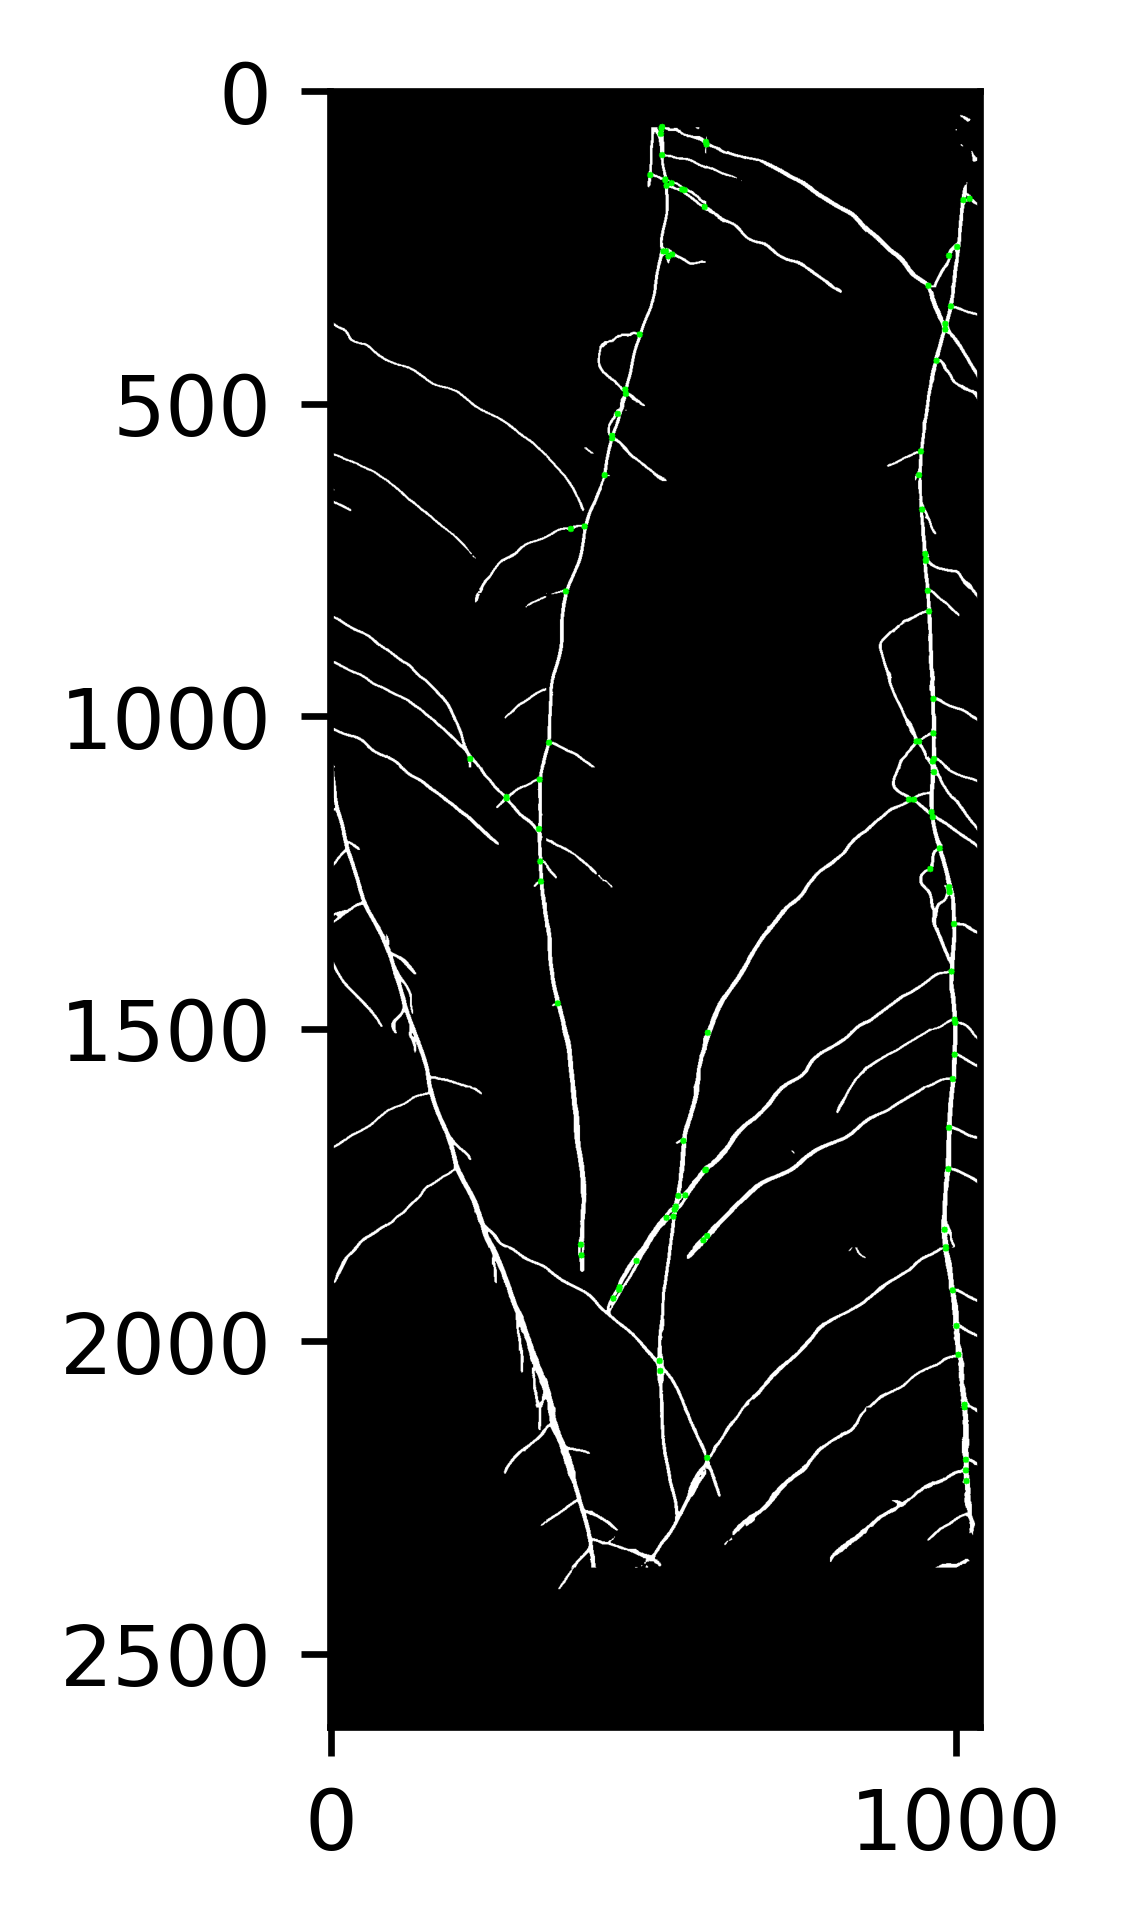

In [53]:
connected_mask = connect_close_enough_starting_nodes('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/final_pipeline_masks/masks/43-19-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected_root_mask.png', "seeding_template.tif")
connected_mask = cv2.cvtColor(connected_mask, cv2.COLOR_BGR2GRAY)
connected_mask = ((connected_mask > 0) * 1).astype('uint8')[454:-1, 2214:3254]

mask_subset_skeleton = skimage.morphology.skeletonize(connected_mask)
connected_mask = (connected_mask * 255).astype('uint8') 
connected_mask = cv2.cvtColor(connected_mask, cv2.COLOR_GRAY2RGB)
mask_subset_skeleton_ob = Skeleton(mask_subset_skeleton)
mask_subset_branch = summarize(mask_subset_skeleton_ob)

G = nx.from_pandas_edgelist(mask_subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
#get the last node - assume that it's the tip of the primary root for now
last_node = max(G.nodes())

# sort the nodes list to go from bottom to top
src_nodes = mask_subset_branch['node-id-src'].unique()
dst_nodes = mask_subset_branch['node-id-dst'].unique()

node_id = mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == 57) & (mask_subset_branch['image-coord-src-1'] == 531)]['node-id-src'].iloc[0]
starting_nodes = []

# loop through all src nodes if it's not in dst nodes -> append to starting nodes array
for node in dst_nodes:
    if node not in src_nodes and (mask_subset_branch['node-id-dst'] == node).sum() == 1:
        starting_nodes.append(node)
        
starting_nodes = sorted(starting_nodes)[::-1]

distance = 0

dictances = {}
angles = {}
vert_ang = {}
for node in starting_nodes:
    # if distance != 0:
    #     break
    # if node == 13319:
    if nx.has_path(G, 14, node):
        if nx.dijkstra_path_length(G, 14, node, weight='branch-distance') < 2600:
            
            all_coords = get_all_coordinates(mask_subset_branch, nx.dijkstra_path(G, 14, node, weight='branch_distance'))
            angle = sum([calculate_angle(all_coords[i], all_coords[i+1], all_coords[i+2]) for i in range(len(all_coords) - 2)])
            for coord in all_coords:
                connected_mask = cv2.circle(connected_mask, (coord[1], coord[0]), 5, (0, 255, 0), -1)
            
            distance = nx.dijkstra_path_length(G, 14, node, weight='branch-distance')  
            vert_ang[node] = calculate_angle_with_vertical(all_coords[0],all_coords[-1])
            dictances[node] = distance
            angles[node] = angle
                    
            # y = mask_subset_branch[mask_subset_branch['node-id-dst'] == node]['image-coord-dst-0'].iloc[0]
            # x = mask_subset_branch[mask_subset_branch['node-id-dst'] == node]['image-coord-dst-1'].iloc[0]
            # angle = calculate_angle_with_vertical([531, 57], [x, y])
            # if angle > 175:
            # 
            #     distance = nx.dijkstra_path_length(G, 14, node, weight='branch-distance')
            #     connected_mask = cv2.circle(connected_mask, (x, y), 5, (0, 255, 0), -1)
fig = plt.figure(figsize=(3.54, 3.54), dpi=600)
plt.imshow(connected_mask, cmap='grey')

In [160]:
def score_segment(length, angle_sum, vertical_angle, max_length, max_angle_sum, max_vertical_angle, length_weight=2.930294006812259, angle_weight=0.28747704730676815, vertical_angle_weight=0.03214807629022745):
    # Normalize length, angle_sum, and vertical_angle to the range [0, 1]
    normalized_length = length / max_length
    normalized_angle = angle_sum / max_angle_sum
    normalized_vertical_angle = vertical_angle / max_vertical_angle
    
    # Invert scores because smaller angles are better
    normalized_angle = 1 - normalized_angle
    normalized_vertical_angle = 1 - normalized_vertical_angle
    
    # Calculate score with given weights
    score = (length_weight * normalized_length + angle_weight * normalized_angle + vertical_angle_weight * normalized_vertical_angle) / (length_weight + angle_weight + vertical_angle_weight)
    return score


In [192]:
def geometric_score(length, angle_sum, vertical_angle, max_length, max_angle_sum, max_vertical_angle, length_importance=8, angle_importance=6, vertical_angle_importance=2):
    # Normalize length and angles
    normalized_length = length / max_length
    normalized_angle_sum = angle_sum / max_angle_sum
    normalized_vertical_angle = vertical_angle / max_vertical_angle
    
    # Invert the angles because smaller is better
    inverse_normalized_angle_sum = 1 / normalized_angle_sum
    inverse_normalized_vertical_angle = 1 / normalized_vertical_angle
    
    # Compute geometric mean of the scores
    score = (normalized_length**length_importance * inverse_normalized_angle_sum**angle_importance * inverse_normalized_vertical_angle**vertical_angle_importance)**(1/(length_importance + angle_importance + vertical_angle_importance))
    
    return score

In [198]:
def custom_score(length, angle_sum, vertical_angle, length_scale_factor=1, angle_penalty_factor=0.01, vertical_angle_importance=0.01):
    # Score based on length (directly proportional)
    length_score = length * length_scale_factor
    
    # Penalize based on angle sum, using a quadratic penalty for larger sums
    angle_penalty = (angle_sum ** 2) * angle_penalty_factor
    
    # Similarly, penalize based on vertical angle, using a quadratic approach
    vertical_angle_penalty = (vertical_angle ** 2) * vertical_angle_importance
    
    # Combine length score with penalties for a final score, adjusting the formula to prevent division by zero
    final_score = length_score / (1 + angle_penalty + vertical_angle_penalty)
    
    return final_score


In [199]:
import pandas as pd

max_length = max(dictances.values())
max_angle_sum = max(angles.values())
max_vert_angle = max(vert_ang.values())

data = [{'node_id': key, 'Distance': dictances[key], 'Angles': angles[key], 'Vert_Angles': vert_ang[key]} for key in dictances]

# Create the DataFrame
df = pd.DataFrame(data)

best_score = -math.inf
best_segment = None
for  key in dictances:
    score = custom_score(dictances[key], angles[key], vert_ang[key])
    if score > best_score:
        best_score = score
        best_segment = key


df['ratio'] = (df['Angles'] + df['Vert_Angles']) / df['Distance'] 
df = df.sort_values(by='ratio', ascending=True)

In [200]:
df

,node_id,Distance,Angles,Vert_Angles,ratio
11,11440,2178.049999,381.449168,88.799155,0.215903
5,13767,2473.885569,478.427073,92.383401,0.230734
6,13319,1962.719913,379.337528,94.087873,0.241209
24,6600,1437.129076,313.944205,66.719383,0.264878
27,5704,1339.229581,309.684619,64.624222,0.279496
1,15881,2546.994083,698.017470,77.158570,0.304349
0,16114,2558.680374,702.747858,77.328429,0.304874
16,9380,1523.009235,374.820849,96.792812,0.309659
2,15199,2459.337229,689.528526,76.678263,0.311550
9,12899,2167.697618,607.367153,75.783345,0.315150


In [201]:
best_segment

587

In [202]:
(max_angle_sum + max_vert_angle) / max_length

0.34126268479382277

In [203]:
1 / ( (max_length + max_vert_angle) / max_angle_sum )

0.28747704730676815

In [204]:
 (max_length + max_angle_sum) / max_vert_angle 

31.106060312043788